# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data EDA and Transformation

In [4]:
def lossRescale(logloss,ymean,ystd):
    loss = (logloss-ymean)/ystd
    return loss
def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

In [5]:
shift=0
colLabel = 'logloss'
colRawLabel = 'loss'
labelColumns = [colLabel, colRawLabel]
data_train_raw[colLabel]=np.log(data_train_raw[colRawLabel]+shift)
print('Skewness of raw loss values: {}'.format(data_train_raw[colRawLabel].skew()))
print('Skewness of log1p loss values: {}'.format(data_train_raw[colLabel].skew()))

Skewness of raw loss values: 3.79495837754
Skewness of log1p loss values: 0.0929745455514


In [6]:
# ymean=0
# ystd=1
ymean=data_train_raw[colLabel].min()
ystd=(data_train_raw[colLabel]-ymean).max()
data_train_raw[colLabel]=lossRescale(data_train_raw[colLabel],ymean,ystd)

In [7]:
# clean outliers in training data
rescaledMean = data_train_raw[colLabel].mean()
rescaledStd = data_train_raw[colLabel].std()
print('Mean of rescaled log1py: {}'.format(rescaledMean))
print('Std of rescaled log1py: {}'.format(rescaledMean))

lbound = rescaledMean-3*rescaledStd
ubound = rescaledMean+3*rescaledStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw[colLabel]>=lbound) & (data_train_raw[colLabel]<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))
print('Skewness of clipped log1p loss: {}'.format(data_train_raw[colLabel].skew()))

Mean of rescaled log1py: 0.668015710303
Std of rescaled log1py: 0.668015710303
Lower clipping bound: 0.466794691997
Upper clipping bound: 0.869236728609
Shape of cleaned data: (187954, 133)
Skewness of clipped log1p loss: 0.127835616059


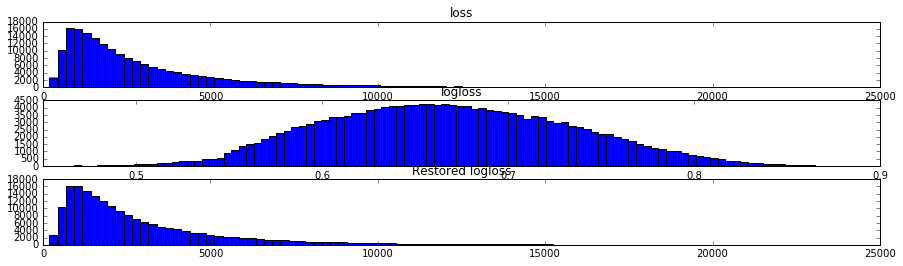

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(data_train_raw[colRawLabel],100)
plt.title(colRawLabel);
plt.subplot(3,1,2)
plt.hist(data_train_raw[colLabel],100)
plt.title(colLabel);
plt.subplot(3,1,3)
plt.hist(lossRestore(data_train_raw[colLabel],ymean,ystd),100)
plt.title('Restored '+colLabel);

In [9]:
print('Are there any null values?')
print(data_train_raw.isnull().any().any())
print(data_test_raw.isnull().any().any())

Are there any null values?
False
False


In [10]:
print('Logarithmic transformed, rescaled, clipped loss:')
data_train_raw[colLabel].describe()

Logarithmic transformed, rescaled, clipped loss:


count    187954.000000
mean          0.668084
std           0.066298
min           0.466798
25%           0.619259
50%           0.665699
75%           0.715343
max           0.869171
Name: logloss, dtype: float64

# Data preparation - labeling cat features with ordinal information encoded

In [11]:
# save label in a seperate serie
labelSs = data_train_raw[colLabel]
labelColumns.append('id')
trainDf = data_train_raw.drop(labelColumns,axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has {} features from the raw data:\n{}'.format(len(trainDf), trainDf.columns))
print('testDf has {} features from the raw data:\n{}'.format(len(testDf),testDf.columns))

trainDf has 187954 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has 125546 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [12]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313500, 130)
(313500, 116) of which are categorical
(313500, 14) of which are continuous


In [13]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
    
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x

dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0J,0G,BU,BC,0C,AS,0S,0A,0O,LB
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0K,0K,BI,CQ,0A,AV,BM,0A,0O,DP
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0F,0A,AB,DK,0A,0C,AF,0A,0I,GK
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0K,0K,BI,CS,0C,0N,AE,0A,0O,DJ
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0G,0B,0H,0C,0C,0Y,BM,0A,0K,CK


In [15]:
features = dataCatAll.columns[0:]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll[feat] = pd.factorize(dataCatAll[feat], sort=True)[0]
dataCatAll.head()
# le.classes_

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,68,49,2,43,17,0,14,300
1,0,1,0,0,0,0,0,0,1,1,...,10,10,56,87,0,46,60,0,14,114
2,0,1,0,0,1,0,0,0,1,1,...,5,0,25,106,0,2,28,0,8,184
3,1,1,0,1,0,0,0,0,1,0,...,10,10,56,89,2,13,27,0,14,108
4,0,1,0,1,0,0,0,0,1,1,...,6,1,7,2,2,24,60,0,10,84


In [16]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll = mms.fit_transform(dataCatAll)

In [17]:
print(x_catAll.shape)
x_catAll

(313500, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.86455331],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.32853026],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.53025937],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.93083573],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.31123919],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.26224784]])

# one-hot-encoding - skipped in order to keep the alphabetical order

In [18]:
# # one-hot-encoding the categorical features
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# split x_train and x_test

In [19]:
# split x_train and x_test
x_train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_test = sp.sparse.hstack((x_catAll[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_train = labelSs.values

# check the dimension of prepared data

In [20]:
print(x_test.shape)
print(x_train.shape)
print(y_train.shape)

(125546, 130)
(187954, 130)
(187954,)


# splite the training data for valication

In [21]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150363, 130)
(150363,)
(37591, 130)
(37591,)


In [22]:
# del x_Train
# del y_Train
# del x_catAll
# del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [23]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [24]:
testList = ['XGBoostTrees']

### XGBoost Trees

In [25]:
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))
# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'mae', mean_absolute_error(preds, labels)

In [26]:
import xgboost as xgb
# from sklearn.grid_search import GridSearchCV

In [27]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [28]:
# params = { 'max_depth': [4, 6, 10], 'min_child_weight':[0,1,2], 'gamma':[0,1,2], \
#            'subsample':[0.5,0.8,1], 'colsample_bytree':[0,1,2], \
#            'eval_metric': 'mae'
#            }
# num_round = 500
# xgbt = GridSearchCV(xgb.XGBRegressor, )

In [29]:
num_round = 3000

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.01,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale
watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist, obj=logregobj, early_stopping_rounds=300)
# gbt = xgb.train(params, d_train_xgb, num_round, watchlist, early_stopping_rounds=300)

[0]	eval-mae:0.164956	train-mae:0.164427
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 300 rounds.
[1]	eval-mae:0.161432	train-mae:0.16091
[2]	eval-mae:0.157988	train-mae:0.157474
[3]	eval-mae:0.15463	train-mae:0.154122
[4]	eval-mae:0.151353	train-mae:0.15085
[5]	eval-mae:0.148156	train-mae:0.14766
[6]	eval-mae:0.145033	train-mae:0.144545
[7]	eval-mae:0.141988	train-mae:0.141509
[8]	eval-mae:0.139013	train-mae:0.138543
[9]	eval-mae:0.136114	train-mae:0.13565
[10]	eval-mae:0.133284	train-mae:0.132827
[11]	eval-mae:0.130529	train-mae:0.130075
[12]	eval-mae:0.127838	train-mae:0.127387
[13]	eval-mae:0.125217	train-mae:0.124768
[14]	eval-mae:0.122667	train-mae:0.122216
[15]	eval-mae:0.120174	train-mae:0.119726
[16]	eval-mae:0.117744	train-mae:0.117296
[17]	eval-mae:0.115371	train-mae:0.114927
[18]	eval-mae:0.113059	train-mae:0.112618
[19]	eval-mae:0.110809	train-mae:0.11037
[20]	eval-mae:0.108613	train-mae

In [30]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1125.68871244


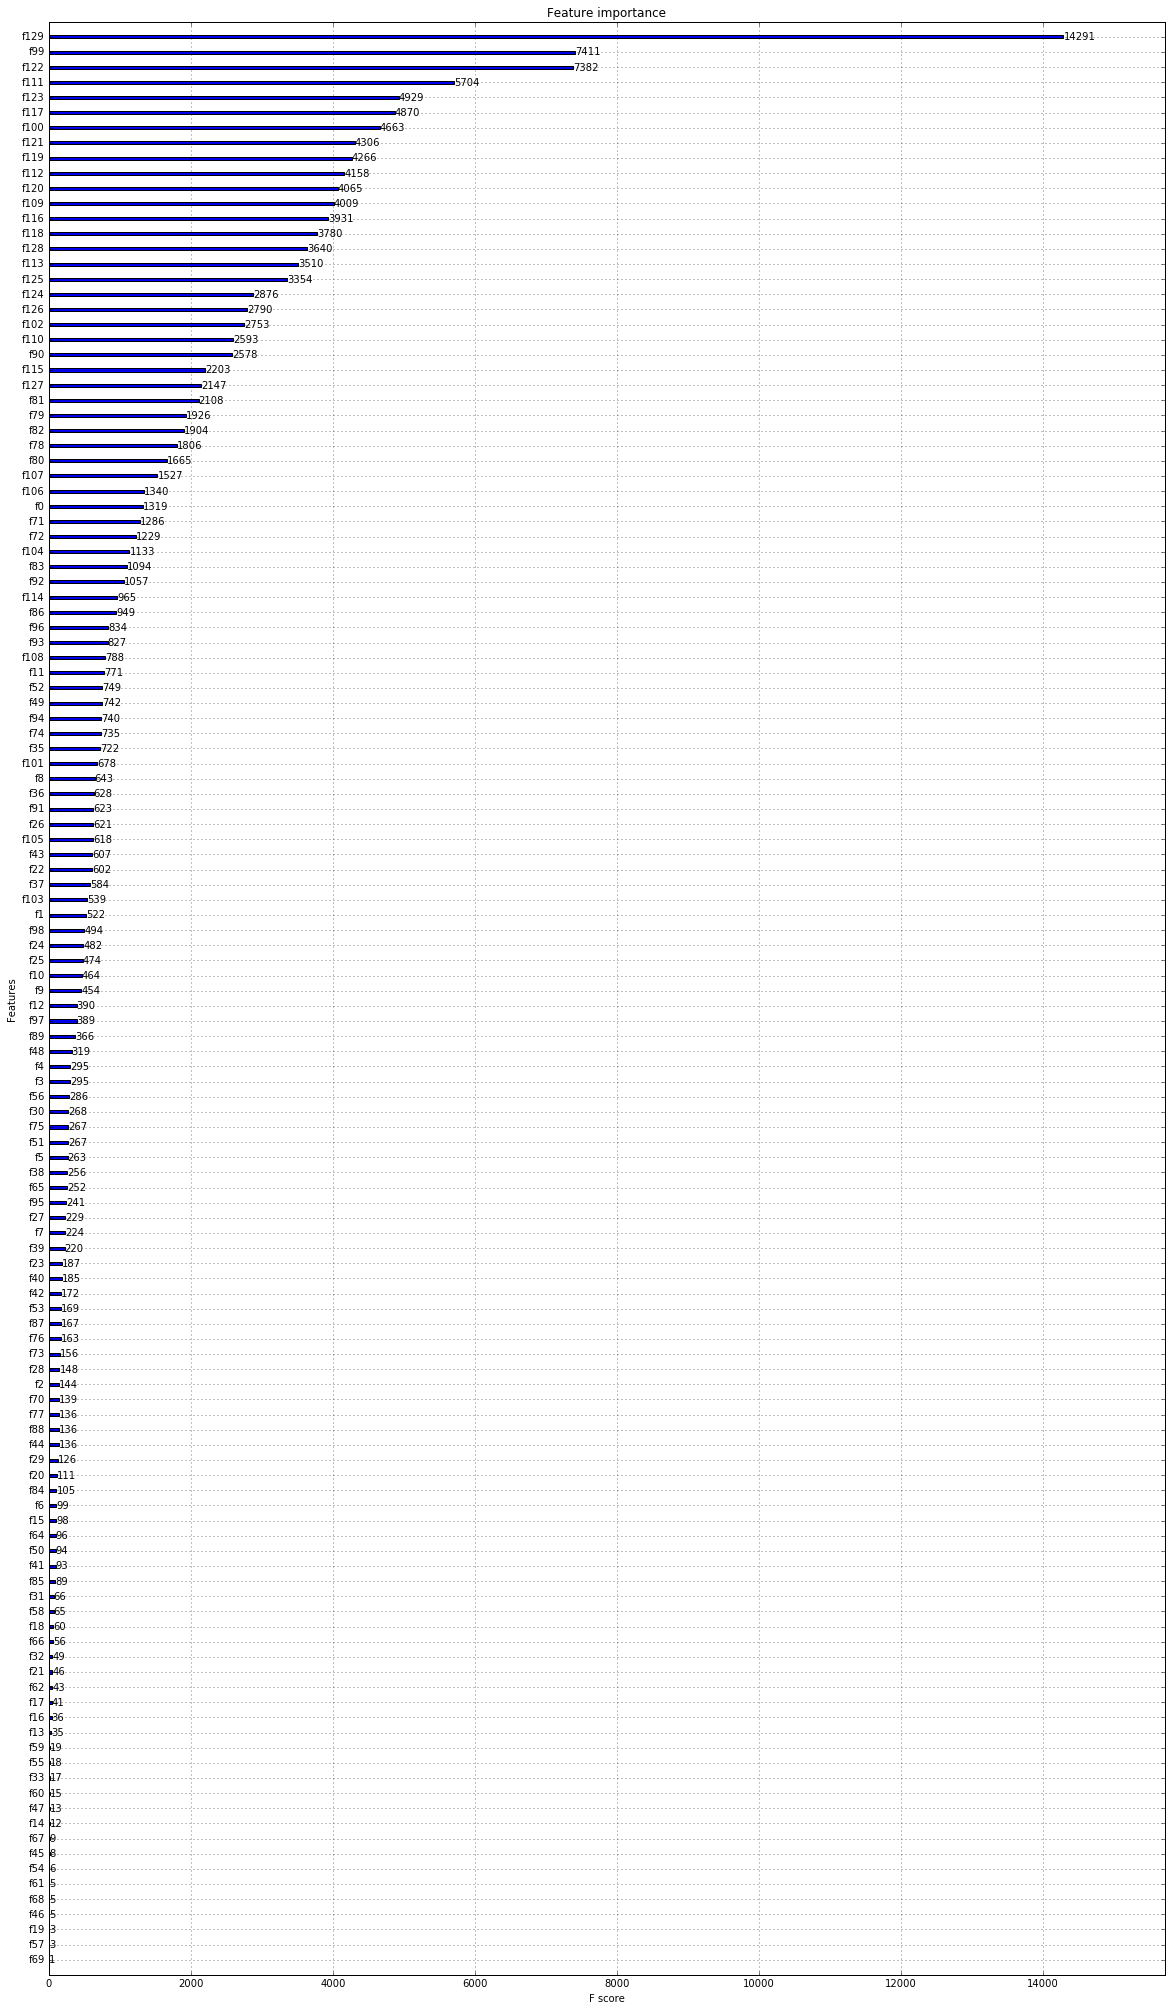

In [31]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() );

In [ ]:
# y_pred_i = gbt.predict(d_test_xgb)
# y_pred.append(lossRestore(y_pred_i,ymean,ystd))
# y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))
y_pred_i = gbt.predict(d_test_xgb)
y_pred.append(y_pred_i)
y_pred_val.append(gbt.predict(x_val_xgb))

# save files for submission

In [ ]:
# # remove the shift
# y_pred = [y_array-shift for y_array in y_pred];
# y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([gbt, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_test, shift]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

In [ ]:
testList
